#Домашнее задание: реализация модели latent diffusion

##Интро
На семинарах мы познакомились с тем, как обучать диффузионную модель. Эти модели были реализованы через пиксельную диффузию, которую на практике уже никто не использует, потому что это вычислительно сложно обучить. На семинарах было разобрано обучение диффузионной модели. Для обучения вам предлагается обучение модели на датасете `nelorth/oxford-flowers` (https://huggingface.co/datasets/nelorth/oxford-flowers)  

##Цель домашнего задания
Научиться реализовать модель диффузии, модель скрытой диффузии и вносить в нее модификации.

### [5 баллов] Реализация обучения диффузионной модели на новом датасете

В этой части задания вам рекомендуется взять код с семинара и адаптировать его под обучение на новом датасете.

**Ожидаемый результат**

В качестве результатов модели, от вас требуется предоставить визуализации генераций, полученных от вашей модели и код обучения модели.

In [1]:
!pip install torchvision
!pip install -q -U einops datasets matplotlib tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 872.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 31.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [2]:
!pip install diffusers
!pip install diffusers -U
!pip install transformers
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 36.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.18.0
    Uninstalling huggingface-hub-0.18.0:
      Successfully uninstalled huggingface-hub-0.18.0


In [3]:
!sudo apt -qq install git-lfs
!git config --global credential.helper store

git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


In [4]:
# Импортируем необходимые библиотеки

import math
from inspect import isfunction
from functools import partial
import numpy as np
from pathlib import Path
import os
import glob

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython import display
from PIL import Image
from tqdm.auto import tqdm
from einops import rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import Compose
from torchvision.transforms import CenterCrop
from torchvision.transforms import Resize
from torchvision.transforms import ToTensor
from torchvision.transforms import Lambda
from torchvision.transforms import ToPILImage

from datasets import load_dataset

from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torch.optim import Adam

from huggingface_hub import notebook_login
from diffusers import DDPMPipeline
from diffusers import DDPMScheduler
from diffusers import UNet2DModel

from diffusers.optimization import get_cosine_schedule_with_warmup

from PIL import Image
import torch
from transformers import CLIPTextModel
from transformers import  CLIPTokenizer
from diffusers import AutoencoderKL
from diffusers import UNet2DConditionModel
from diffusers import PNDMScheduler
from diffusers import UniPCMultistepScheduler
from dataclasses import dataclass

from huggingface_hub import HfFolder
from huggingface_hub import Repository
from huggingface_hub import whoami

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [5]:
# Определяем вспомогательные функции

# Проверка на существование переменной
def exists(x):
    return x is not None

# Задать значение по умолчанию для переменной
def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

# Модуль для реализации skip-connections (остаточных связей)
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

# Модуль для увеличения разрешения изображения
def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

# Модуль для уменьшения разрешения изображения
def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

In [6]:
# Модуль для генерации позиционных эмбеддингов на основе синусоид
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [7]:
# Базовый блок для сети
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

# Остаточный блок для сети ResNet
class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)

# Блок ConvNext для архитектуры сети
class ConvNextBlock(nn.Module):
    """https://arxiv.org/abs/2201.03545"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if exists(self.mlp) and exists(time_emb):
            assert exists(time_emb), "time embedding must be passed in"
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)

In [8]:
# Модуль внимания
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

In [9]:
# Модуль линейного внимания
class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1),
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

In [10]:
# Модуль для нормализации перед применением функции активации
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

In [11]:
# Основная архитектура сети U-Net
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2,
    ):
        super().__init__()

        # определяем размерности
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        if use_convnext:
            block_klass = partial(ConvNextBlock, mult=convnext_mult)
        else:
            block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # уровни
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []

        # понижение дискретизации
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # узкое место
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # повышение дискретизации
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)

In [12]:
# Различные расписания для параметра beta
def cosine_beta_schedule(timesteps, s=0.008):
    """
    косинусный график как в https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

In [13]:
# Устанавливаем количество временных шагов
timesteps = 200

# определяем beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# определяем альфа
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# вычисления для диффузии q(x_t | x_{t-1}) и других
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# вычисления для постериорного q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

# Извлечение нужных значений из массива
def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [14]:
# Устанавливаем размер изображения для дальнейших преобразований
image_size = 128

# Определение трансформаций для изображений
transform = Compose([
    Resize(image_size), # Изменяем размер изображения
    CenterCrop(image_size), # Обрезаем изображение по центру
    ToTensor(), # Преобразуем в torch.tensor с размерностью CHW и значениями в [0, 1]
    Lambda(lambda t: (t * 2) - 1), # Сжимаем значения в диапазон [-1, 1]
])

In [15]:
# Обратные преобразования для изображений
reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2), # Преобразуем значения в диапазон [0, 1]
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW в HWC
     Lambda(lambda t: t * 255.), # Преобразуем значения в диапазон [0, 255]
     Lambda(lambda t: t.numpy().astype(np.uint8)), # Преобразуем тензор в numpy и изменяем тип на uint8
     ToPILImage(), # Преобразуем в изображение PIL
])

In [16]:
# Функция для прямой диффузии
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

In [17]:
# Функция для получения зашумленного изображения
def get_noisy_image(x_start, t):
    # Добавляем шум
    x_noisy = q_sample(x_start, t=t)

    # Возвращаем к формату PIL image
    noisy_image = reverse_transform(x_noisy.squeeze())
    return noisy_image

In [18]:
# Устанавливаем seed для воспроизводимости
torch.manual_seed(0)

# Функция для визуализации списка изображений
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # делаем 2d сетку, даже если это 1 строка
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [19]:
# Функция потерь для декодера
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

In [20]:
# Загружаем датасет
dataset = load_dataset('nelorth/oxford-flowers')

# Выводим датасет train и test
train_dataset = dataset['train']

# Итерация по датасету
for example in train_dataset:
    image = example["image"]
    label = example["label"]

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/7169 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1020 [00:00<?, ? examples/s]

In [21]:
# задаем параметры
image_size = 28
channels = 1
batch_size = 128

# Определение трансформаций для изображений
transform = Compose([
            transforms.Resize((image_size, image_size)), # Изменение размера изображения
            transforms.RandomHorizontalFlip(), # Случайное горизонтальное отражение
            transforms.ToTensor(), # Преобразование в тензор
            transforms.Lambda(lambda t: (t * 2) - 1) # Нормализация в диапазон [-1, 1]
])

In [22]:
# Функция преобразования изображений
def transforms(examples):
    examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
    del examples["image"]
    return examples

transformed_dataset = dataset.with_transform(transforms).remove_columns("label")

# Создание DataLoader
dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size, shuffle=True)

batch = next(iter(dataloader))
print(batch.keys())

dict_keys(['pixel_values'])


In [23]:
# Функция для прямой диффузии изображения
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

In [24]:
# Итерация по временным шагам для диффузии
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # начинаем с чистого шума (для каждого примера в батче)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

In [25]:
def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr
# Создаем папку для сохранения результатов
results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000

In [26]:
# Определение устройства для обучения (GPU или CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Инициализация модели и перемещение на устройство
model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)

# Определение оптимизатора
optimizer = Adam(model.parameters(), lr=1e-3)

In [27]:
# Количество эпох обучения
epochs = 30

# Обучение модели
for epoch in range(epochs):
    # Обертываем dataloader с помощью tqdm для отображения индикатора прогресса
    for step, batch in tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch + 1}/{epochs}"):
        optimizer.zero_grad()

        batch_size = batch["pixel_values"].shape[0]
        batch = batch["pixel_values"].to(device)

        # Случайная выборка временных шагов для каждого изображения в батче
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()

        # Расчет функции потерь
        loss = p_losses(model, batch, t, loss_type="huber")

        # Вывод значения функции потерь каждые 100 шагов
        if step % 100 == 0:
            print("Loss:", loss.item())

        # Обратное распространение ошибки
        loss.backward()

        # Шаг оптимизации
        optimizer.step()

        # Сохранение сгенерированных изображений каждые 1000 шагов
        if step != 0 and step % save_and_sample_every == 0:
            milestone = step // save_and_sample_every
            batches = num_to_groups(4, batch_size)
            all_images_list = list(map(lambda n: sample(model, batch_size=n, channels=channels), batches))
            all_images = torch.cat(all_images_list, dim=0)
            all_images = (all_images + 1) * 0.5
            save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)

Epoch 1/30:   0%|          | 0/57 [00:00<?, ?it/s]

Loss: 0.44244882464408875


Epoch 2/30:   0%|          | 0/57 [00:00<?, ?it/s]

Loss: 0.14896318316459656


Epoch 3/30:   0%|          | 0/57 [00:00<?, ?it/s]

Loss: 0.09994422644376755


Epoch 4/30:   0%|          | 0/57 [00:00<?, ?it/s]

Loss: 0.08212342113256454


Epoch 5/30:   0%|          | 0/57 [00:00<?, ?it/s]

Loss: 0.0990503802895546


Epoch 6/30:   0%|          | 0/57 [00:00<?, ?it/s]

Loss: 0.079686738550663


Epoch 7/30:   0%|          | 0/57 [00:00<?, ?it/s]

Loss: 0.07653925567865372


Epoch 8/30:   0%|          | 0/57 [00:00<?, ?it/s]

Loss: 0.08022468537092209


Epoch 9/30:   0%|          | 0/57 [00:00<?, ?it/s]

Loss: 0.05304215848445892


Epoch 10/30:   0%|          | 0/57 [00:00<?, ?it/s]

Loss: 0.08692445605993271


Epoch 11/30:   0%|          | 0/57 [00:00<?, ?it/s]

Loss: 0.07800612598657608


Epoch 12/30:   0%|          | 0/57 [00:00<?, ?it/s]

Loss: 0.062418848276138306


Epoch 13/30:   0%|          | 0/57 [00:00<?, ?it/s]

Loss: 0.06427892297506332


Epoch 14/30:   0%|          | 0/57 [00:00<?, ?it/s]

Loss: 0.06590722501277924


Epoch 15/30:   0%|          | 0/57 [00:00<?, ?it/s]

Loss: 0.07628095149993896


Epoch 16/30:   0%|          | 0/57 [00:00<?, ?it/s]

Loss: 0.08190549165010452


Epoch 17/30:   0%|          | 0/57 [00:00<?, ?it/s]

Loss: 0.07702062278985977


Epoch 18/30:   0%|          | 0/57 [00:00<?, ?it/s]

Loss: 0.05721816048026085


Epoch 19/30:   0%|          | 0/57 [00:00<?, ?it/s]

Loss: 0.06939110159873962


Epoch 20/30:   0%|          | 0/57 [00:00<?, ?it/s]

Loss: 0.07301221787929535


Epoch 21/30:   0%|          | 0/57 [00:00<?, ?it/s]

Loss: 0.09137089550495148


Epoch 22/30:   0%|          | 0/57 [00:00<?, ?it/s]

Loss: 0.07422401010990143


Epoch 23/30:   0%|          | 0/57 [00:00<?, ?it/s]

Loss: 0.07918991893529892


Epoch 24/30:   0%|          | 0/57 [00:00<?, ?it/s]

Loss: 0.06881951540708542


Epoch 25/30:   0%|          | 0/57 [00:00<?, ?it/s]

Loss: 0.07933817058801651


Epoch 26/30:   0%|          | 0/57 [00:00<?, ?it/s]

Loss: 0.06202191486954689


Epoch 27/30:   0%|          | 0/57 [00:00<?, ?it/s]

Loss: 0.06840766221284866


Epoch 28/30:   0%|          | 0/57 [00:00<?, ?it/s]

Loss: 0.05838329717516899


Epoch 29/30:   0%|          | 0/57 [00:00<?, ?it/s]

Loss: 0.06394750624895096


Epoch 30/30:   0%|          | 0/57 [00:00<?, ?it/s]

Loss: 0.07167927920818329


Ваши визуализации

In [ ]:
#plot([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 50, 100, 150, 199]])

NameError: ignored

In [28]:
# сэмплирует 64 изображения
samples = sample(model, image_size=image_size, batch_size=16, channels=channels)

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

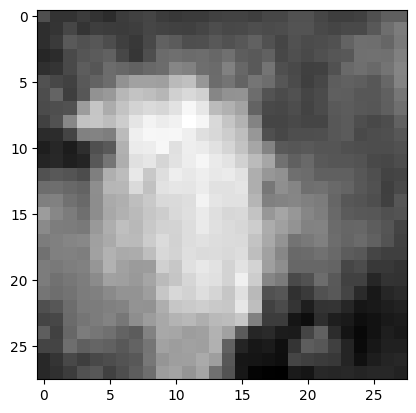

In [29]:
# показывает один случайный
random_index = 10
plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels), cmap="gray")

In [30]:
# создаем gif процесса шумоподавления:
random_index = 10

ims = []
for i in range(timesteps):
    t = np.uint8((samples[i][random_index].clip(-1, 1) + 1) / 2 * 255)
    im = Image.fromarray(t.squeeze(0)).resize((512, 512)).convert('P')
    ims.append(im)


ims[0].save('diffusion.gif',
               save_all=True, append_images=ims[1:], optimize=False, duration=40, loop=0)

### [3 балла] Реализация обучения модели latent diffusion

Напоминание про реализацию модели [Latent Diffusion](https://nn.labml.ai/diffusion/stable_diffusion/latent_diffusion.html)

Для того, чтобы из кода обучения Diffusion получить обучения Latent Diffusion, вам нужно добавить VQ-VAE и заморозить! и обрабатывать изображения с помощью `vae.encode`. Далее полученные latent, подаются в стандартный пайплайн обучения. Учтите, что latent имеет меньшую размерность и вам может понадобиться уменьшить число слоёв в архитектуре UNet.

В качестве модели VQ-VAE вы можете воспользоваться предобученным VQ-VAE от Stable diffusion.

**Ожидаемый результат**

В качестве результатов модели, от вас требуется предоставить визуализации генераций, полученных от вашей модели, и код обучения модели.

diffusion_pytorch_model.safetensors not found


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

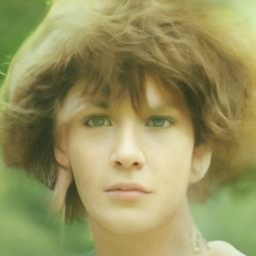

In [31]:
# Инициализация и вход в аккаунт
notebook_login()

# Загрузка предварительно обученной модели DDPM для CelebA-HQ (размер изображения 256x256) и перенос на GPU
ddpm = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256").to("cuda")

# Генерация изображения с использованием модели DDPM (с 25 шагами вывода)
image = ddpm(num_inference_steps=30).images[0]

# Отображение сгенерированного изображения
image

In [32]:
# Загрузка шагов для предварительно обученной модели
scheduler = DDPMScheduler.from_pretrained("google/ddpm-celebahq-256")

# Загрузка архитектуры UNet2D для предварительно обученной модели и перенос на GPU
model = UNet2DModel.from_pretrained("google/ddpm-celebahq-256").to("cuda")

# Установка числа временных шагов для планировщика
scheduler.set_timesteps(50)

# Вывод доступных временных шагов
scheduler.timesteps

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


tensor([980, 960, 940, 920, 900, 880, 860, 840, 820, 800, 780, 760, 740, 720,
        700, 680, 660, 640, 620, 600, 580, 560, 540, 520, 500, 480, 460, 440,
        420, 400, 380, 360, 340, 320, 300, 280, 260, 240, 220, 200, 180, 160,
        140, 120, 100,  80,  60,  40,  20,   0])

In [33]:
# Определение размеров изображения и создание начального шума
sample_size = model.config.sample_size
noise = torch.randn((1, 3, sample_size, sample_size)).to("cuda")

In [34]:
input = noise

# Проход по всем временным шагам для генерации изображения
for t in scheduler.timesteps:
    with torch.no_grad():
        noisy_residual = model(input, t).sample
    previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
    input = previous_noisy_sample

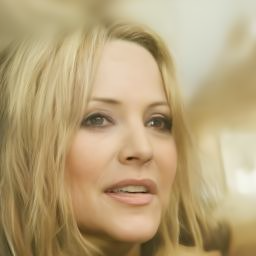

In [35]:
# Конвертация генерированного изображения в формат PIL
image = (input / 2 + 0.5).clamp(0, 1)
image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
image = Image.fromarray((image * 255).round().astype("uint8"))
image

**Теперь начнем писать код для SD (Stable Difussion)**

In [36]:
# Загрузка дополнительных компонентов для генерации изображений с условиями
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="text_encoder")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [37]:
# Используем другой планировщик
scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

# Переносим модели на GPU
torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): LoRACompatibleConv(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): LoRACompatibleLinear(in_features=320, out_features=320, bias=False)
                (to_k): LoRACompatibleLinear(in_features=320, out_features=320, bias=False)
              

In [38]:
# Замораживаем VAE и text_encoder для обучения
vae.requires_grad_(False)
text_encoder.requires_grad_(False)
unet.train()

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): LoRACompatibleConv(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): LoRACompatibleLinear(in_features=320, out_features=320, bias=False)
                (to_k): LoRACompatibleLinear(in_features=320, out_features=320, bias=False)
              

In [39]:
# Конфигурация для обучения
@dataclass
class TrainingConfig:
    image_size = 128  # сгенерированное разрешение изображения
    train_batch_size = 16
    eval_batch_size = 16  # сколько изображений мы можем сэмплировать во время eval
    num_epochs = 5
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 1
    save_model_epochs = 1
    mixed_precision = 'fp16'  # `no` для float32, `fp16` для автоматической смешанной точности
    output_dir = 'ddpm-butterflies-128'  # имя модели локально и на HF Hub

    push_to_hub = False  # Если True, то загружаем сохраненную модель в HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # Если True, то перезаписываем старую модель при повторном запуске ноутбука
    seed = 0

config = TrainingConfig()

In [40]:
# Определение текстового запроса для генерации изображения
prompt = ["8k, realistic, unreal engine, ancient greek city, ancient Georgia, ancient Armenia, ancient Greece, cyberpunk, futuristic, Athens, Asher Brown Durand, Tyler Edlin, Kawase Hasui, futuristic, lively busy city in ancient greek decorations, megapolis, paganpunk, cyberpunk futuristic city, Tsutomu Nihei"]
height = 512  # высота Stable Diffusion по умолчанию
width = 512  # ширина Stable Diffusion по умолчанию
num_inference_steps = 25  # Количество шагов шумоподавления
guidance_scale = 0  # Масштаб classifier-free guidance
generator = torch.manual_seed(0)  # Seed generator чтобы создать начальный скрытый шума
batch_size = len(prompt)

In [41]:
# Токенизация текстового запроса
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

# Получение текстовых эмбеддингов
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

max_length = text_input.input_ids.shape[-1]

# Токенизация пустой строки для получения "базового" эмбеддинга
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

# Комбинация базовых и текстовых эмбеддингов
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [42]:
# Проверка на соответствие размерности
2 ** (len(vae.config.block_out_channels) - 1) == 8

True

In [43]:
# Создание начального скрытого состояния
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
)
latents = latents.to(torch_device)

<ipython-input-43-ad9deafa4b00>:3: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


In [44]:
latents = latents * scheduler.init_noise_sigma
# Установка количества временных шагов для планировщика
scheduler.set_timesteps(num_inference_steps)

In [45]:
# Проход по всем временным шагам для генерации изображения
for t in tqdm(scheduler.timesteps):
    # Расширение скрытого состояния для руководства
    latent_model_input = torch.cat([latents] * 2)

    # Масштабирование входа модели
    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # Предсказание остаточного шума
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # Применение руководства без классификатора
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # Обратный шаг во времени для получения предыдущего шумного изображения
    latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/25 [00:00<?, ?it/s]

In [46]:
# Масштабирование и декодирование скрытого состояния с помощью VAE
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

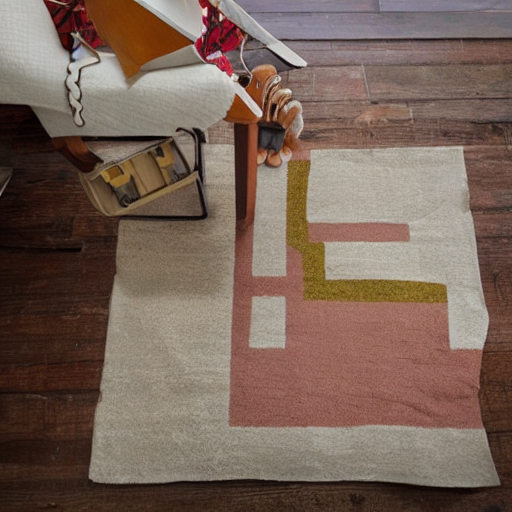

In [47]:
# Преобразование и нормализация изображения
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")

# Преобразование массива в объекты PIL Image
pil_images = [Image.fromarray(image) for image in images]

# Вывод сгенерированного изображения
pil_images[0]

**Теперь обучаем свою сеть**

In [48]:
torch_device = 'cuda'

In [49]:
@dataclass
class TrainingConfig:
    image_size = 128  # сгенерированное разрешение изображения
    train_batch_size = 8  # размер батча во время обучения
    eval_batch_size = 8  # размер батча во время оценки (сколько изображений мы можем сэмплировать во время eval)
    num_epochs = 7  # количество эпох обучения
    gradient_accumulation_steps = 1  # количество шагов для накопления градиента
    learning_rate = 1e-4  # скорость обучения
    lr_warmup_steps = 500  # количество шагов для "разогрева" скорости обучения
    save_image_epochs = 1  # через сколько эпох сохранять изображения
    save_model_epochs = 1  # через сколько эпох сохранять модели
    mixed_precision = 'fp16'  # используемая точность (`no` для float32, `fp16` для автоматической смешанной точности)
    output_dir = 'ddpm-butterflies-128'  # путь для сохранения модели

    # настройки для загрузки модели в HF Hub
    push_to_hub = False  # если True, то загружаем сохраненную модель в HF Hub
    hub_private_repo = False  # если True, репозиторий будет приватным
    overwrite_output_dir = True  # если True, перезаписываем существующую модель при повторном запуске
    seed = 0  # начальное значение для генератора случайных чисел

# Создание экземпляра конфигурации
config = TrainingConfig()

In [50]:
# Установка датасета
config.dataset_name = "huggan/pokemon"

# Загрузка датасета
dataset = load_dataset(config.dataset_name, split="train")

Repo card metadata block was not found. Setting CardData to empty.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/7357 [00:00<?, ? examples/s]

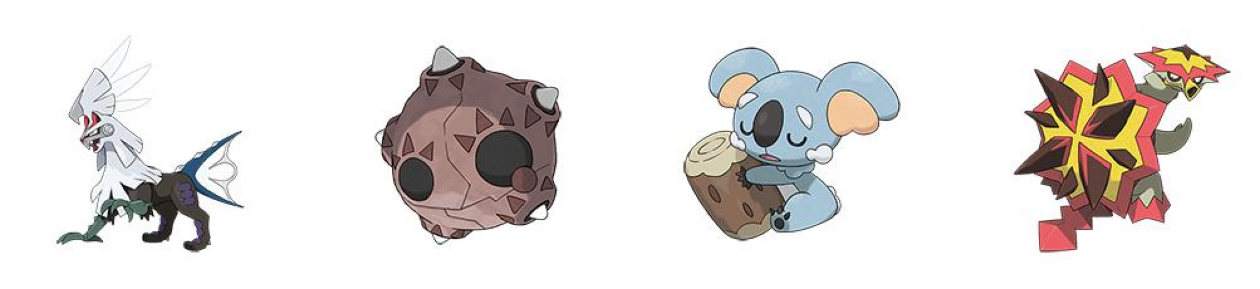

In [51]:
# Визуализация изображений из датасета
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[5:9]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

In [52]:
from torchvision import transforms

In [53]:
# Определение препроцессинга для изображений
preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),  # изменение размера изображения
        transforms.RandomHorizontalFlip(),  # случайное горизонтальное отражение
        transforms.ToTensor(),  # преобразование изображения в тензор
        transforms.Normalize([0.5], [0.5]),  # нормализация изображения
    ]
)

# Функция для преобразования изображений
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

# Применение препроцессинга к датасету
dataset.set_transform(transform)

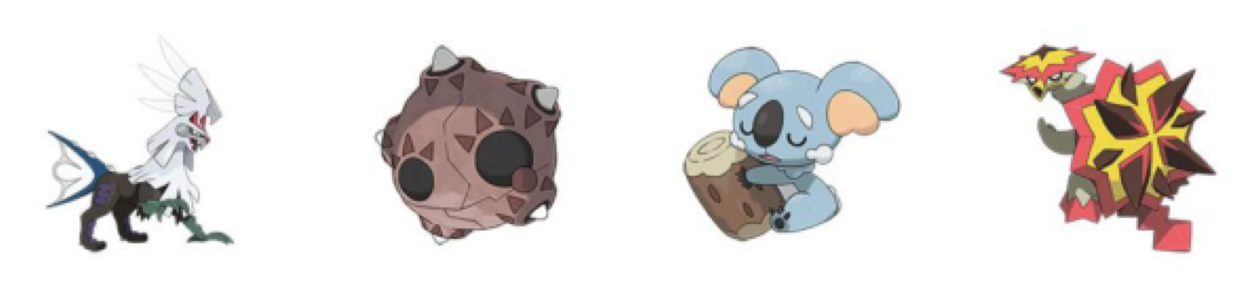

In [54]:
# Визуализация преобразованных изображений
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[5:9]["images"]):
    axs[i].imshow(image.permute(1, 2, 0).numpy() / 2 + 0.5)
    axs[i].set_axis_off()
fig.show()

In [55]:
# Создание даталоадера для обучения
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

In [56]:
# Определение модели UNet
model = UNet2DModel(
    sample_size=config.image_size,  # разрешение изображения
    in_channels=3,  # количество входных каналов (3 для RGB изображений)
    out_channels=3,  # количество выходных каналов
    layers_per_block=2,  # количество ResNet слоев в каждом блоке UNet
    block_out_channels=(128, 128, 256, 256, 512, 512),  # количество выходных каналов для каждого блока UNet
    down_block_types=(
        "DownBlock2D",  # стандартный блок снижения разрешения
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # блок снижения разрешения с механизмом внимания
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # стандартный блок повышения разрешения
        "AttnUpBlock2D",  # блок повышения разрешения с механизмом внимания
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
    ),
)

In [57]:
# Проверка размеров входного и выходного изображения для модели
sample_image = dataset[0]['images'].unsqueeze(0)
print('Input shape:', sample_image.shape)
print('Output shape:', model(sample_image, timestep=0).sample.shape)

Input shape: torch.Size([1, 3, 128, 128])
Output shape: torch.Size([1, 3, 128, 128])


### [2 балла] Анализ влияния scheduler на качество генерации

 На качество генерации может влиять используемый scheduler и число шагов, поэтому в этой части домашнего задания, вам предлагается происследовать визуально как scheduler и число шагов влияют на качество генерации. Вам предлагается рассмотреть качество генерации на 10 различных числах шагов и,  используя различные scheduler.


 В качестве scheduler предлагается стандартный DDPM, DDIM, DPMSolver (Другие scheduler не воспрещаются). Обратите внимание, что DDIM и DPMSolver являются детерминированными scheduler, а значит результат у них должен получаться одиннаковый.

 **Ожидаемый результат**

 В качестве результатов в этом пункте от вас требуется предоставить визуализации картинок в различных вариации числа шагов и scheduler и сделать выводы, какие параметры лучше использовать. Вы можете выполнить эту часть, не используя обученную выше модель, а используя стандартные pipeline StableDiffusion

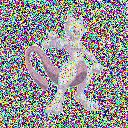

In [58]:
# Определение шумового расписания для модели
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

# Генерация случайного шума и добавление его к изображению
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

# Визуализация зашумленного изображения
Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [59]:
# Предсказание модели для зашумленного изображения
noise_pred = model(noisy_image, timesteps).sample

# Расчет функции потерь на основе разницы между предсказанным и истинным шумом
loss = F.mse_loss(noise_pred, noise)

# Определение оптимизатора для обучения модели
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

In [60]:
# Определение косинусной скорости обучения
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [61]:
# Функция для создания сетки из изображений
def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

# Функция для оценки модели после каждой эпохи обучения
def evaluate(config, epoch, pipeline):
    # Сэмплирование изображений из случайного шума
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images

    # Сборка сетки из сэмплированных изображений
    image_grid = make_grid(images, rows=4, cols=4)

    # Сохранение сетки изображений
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [62]:
# torch_device = 'cuda'
# Перемещение модели на устройство для обучения (GPU или CPU)
model = model.to(torch_device)

In [63]:
# Определение полного имени репозитория для загрузки модели на HF Hub
def get_full_repo_name(model_id: str, organization: str = None, token: str = None):
    if token is None:
        token = HfFolder.get_token()
    if organization is None:
        username = whoami(token)["name"]
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"

# Главный цикл обучения модели
def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    global_step = 0

    # Начало процесса обучения
    for epoch in tqdm(range(config.num_epochs), desc="Epochs"):
        progress_bar = tqdm(total=len(train_dataloader), desc=f"Epoch {epoch+1}/{config.num_epochs}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images'].to(torch_device)

            # Генерация шума для добавления к чистым изображениям
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Случайный выбор временных шагов для каждого изображения в пакете
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

            # Добавление шума к чистым изображениям
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            # Предсказание модели для зашумленных изображений
            noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

            # Расчет функции потерь и обновление весов модели
            loss = F.mse_loss(noise_pred, noise)
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            global_step += 1

        # Оценка модели после каждой эпохи
        pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)
        if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
            evaluate(config, epoch, pipeline)
        if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
            pipeline.save_pretrained(config.output_dir)

In [64]:
import torch

torch.cuda.empty_cache()

In [65]:
# Запуск обучения модели
train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

Epochs:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/7:   0%|          | 0/920 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:134: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2/7:   0%|          | 0/920 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3/7:   0%|          | 0/920 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4/7:   0%|          | 0/920 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 5/7:   0%|          | 0/920 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 6/7:   0%|          | 0/920 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 7/7:   0%|          | 0/920 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [66]:
# Создание пайплайна для модели после обучения
pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)

# Оценка обученной модели
evaluate(config, 0, pipeline)

  0%|          | 0/1000 [00:00<?, ?it/s]

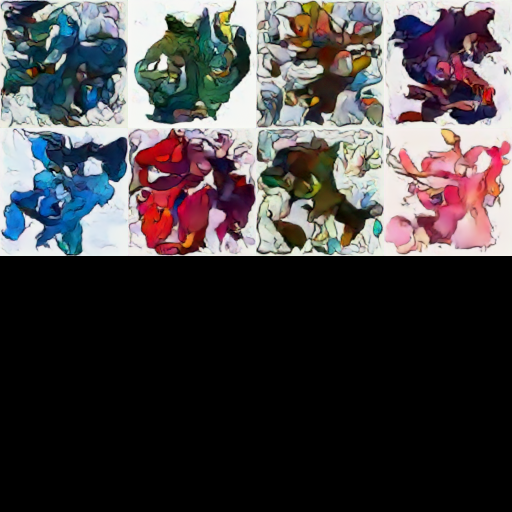

In [67]:
# Визуализация сгенерированных изображений после обучения
sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])

Видно, что нейронная сеть отрабатывает не идеально, к сожалению. За отведенное время на домашнюю работу я провел не мало эксперементов, но, к сожалению, нехватка вычислительных ресурсов в google collab и затрачиваемое время на обучение NN не дало проработать архитектуру и подобрать наилучшие параметры. Прошу учесть данный момент при проверке работы.

### Дополнительное задание [дополнительный 1 балл]. Модификации conditional guidance*
*Дополнительный балл не умножается на коэффициент домашнего задания*

---

Далее, вам предлагается реализовать conditional guidance на этом датасете. Как уже упоминалось на лекции механизм conditional guidance позволяет вам генерировать изображения с выбранными вами условиями (картинки определенных цветков, например). На семинаре 2 был показан участок кода, который реализовал условную генерацию, однако для этого вам нужно добавить прокидывание условия в UNet и чуть поменять процесс условной генерации. При реализации вы можете опираться адаптировать следующую [реализацию](https://github.com/TeaPearce/Conditional_Diffusion_MNIST).

**Ожидаемый результат**

В качестве результатов модели, от вас требуется предоставить визуализации генераций, полученных от вашей модели, и код обучения модели.


In [68]:
# Определение текстового запроса для генерации изображения
prompt = ["8k, realistic, unreal engine, ancient greek city, ancient Georgia, ancient Armenia, ancient Greece, cyberpunk, futuristic, Athens, Asher Brown Durand, Tyler Edlin, Kawase Hasui, futuristic, lively busy city in ancient greek decorations, megapolis, paganpunk, cyberpunk futuristic city, Tsutomu Nihei"]
height = 512  # высота Stable Diffusion по умолчанию
width = 512  # ширина Stable Diffusion по умолчанию
num_inference_steps = 25  # Количество шагов шумоподавления
guidance_scale = 7.5  # Масштаб classifier-free guidance
generator = torch.manual_seed(0)  # Seed generator чтобы создать начальный скрытый шума
batch_size = len(prompt)

In [69]:
# Токенизация текстового запроса
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

# Получение текстовых эмбеддингов
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

max_length = text_input.input_ids.shape[-1]

# Токенизация пустой строки для получения "базового" эмбеддинга
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

# Комбинация базовых и текстовых эмбеддингов
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [70]:
# Создание начального скрытого состояния
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
)
latents = latents.to(torch_device)

<ipython-input-70-ad9deafa4b00>:3: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


In [71]:
latents = latents * scheduler.init_noise_sigma
# Установка количества временных шагов для планировщика
scheduler.set_timesteps(num_inference_steps)

In [72]:
# Проход по всем временным шагам для генерации изображения
for t in tqdm(scheduler.timesteps):
    # Расширение скрытого состояния для руководства
    latent_model_input = torch.cat([latents] * 2)

    # Масштабирование входа модели
    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # Предсказание остаточного шума
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # Применение руководства без классификатора
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # Обратный шаг во времени для получения предыдущего шумного изображения
    latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/25 [00:00<?, ?it/s]

In [73]:
# Масштабирование и декодирование скрытого состояния с помощью VAE
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

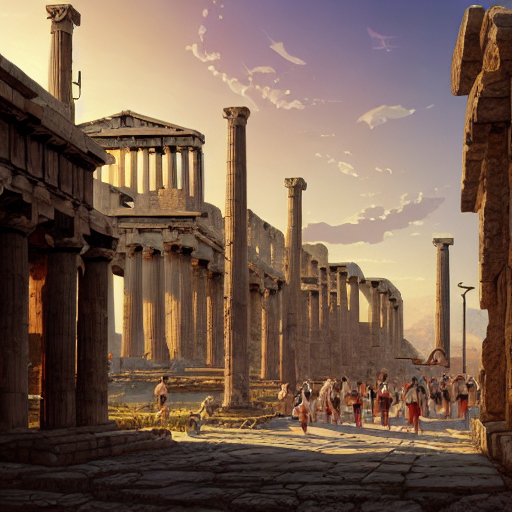

In [74]:
# Преобразование и нормализация изображения
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")

# Преобразование массива в объекты PIL Image
pil_images = [Image.fromarray(image) for image in images]

# Вывод сгенерированного изображения
pil_images[0]

Наш промт отработал не идеально, видны так называемые "инсульты", но при этом, та тематика, которую мы планировали получить, в целом увенчалась успешно благодаря "guidance_scale = 7.5".